# Training quantum kernels for 2-classes classification tasks.

## Packages importing 

In [39]:
import numpy as np

# importing Qiskit
from qiskit import assemble, transpile
from qiskit.quantum_info import Statevector, Operator
import qiskit.quantum_info as qi
from qiskit.circuit.library import PauliFeatureMap, ZZFeatureMap
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit, QuantumRegister, ClassicalRegister

# import basic plot tools
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# importing Qiskit ML
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data

# Importing Sklearn 
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.model_selection import train_test_split

## Model as a class

In [40]:
def hs_dist(rho,sigma):
  return np.trace(np.matmul(rho,rho) - 2*np.matmul(rho,sigma) + np.matmul(sigma,sigma))

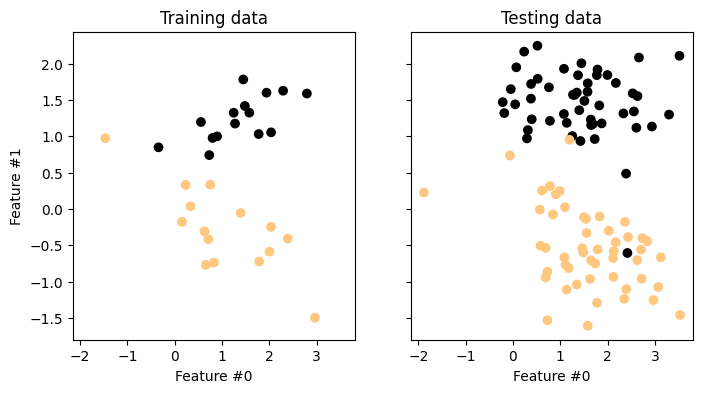

In [41]:
def data_prep(dataset, train_size):
    X_train, X_test, y_train, y_test = dataset 

    # Separated class preparation
    class_1 = [i for i in range(0,len(y_train)) if y_train[i]==0]
    class_2 = [i for i in range(0,len(y_train)) if y_train[i]==1]
    X_train_1 = np.array([X_train[x] for x in class_1])
    X_train_2 = np.array([X_train[x] for x in class_2])
    X_train = np.array([X_train[x] for x in (class_1+class_2)])
    y_train = np.array([y_train[x] for x in (class_1[:train_size]+class_2[:train_size])])

    # Chose the first 30 points for training
    X_train_1 = X_train_1[:train_size]
    X_train_2 = X_train_2[:train_size]
    X_train = np.concatenate((X_train_1, X_train_2), axis=0)

    class_1_test = [i for i in range(0,len(y_test)) if y_test[i]==0]
    class_2_test = [i for i in range(0,len(y_test)) if y_test[i]==1]
    # X_test_1 = np.array([X_test[x] for x in class_1_test])
    # X_test_2 = np.array([X_test[x] for x in class_2_test])
    X_test = np.array([X_test[x] for x in (class_1_test+class_2_test)])
    y_test = np.array([y_test[x] for x in (class_1_test+class_2_test)])

    dataset_prep = X_train, X_test, y_train, y_test
    return dataset_prep

# Generation of the whole dataset
# X, y = make_moons(n_samples=400, noise=0.15, random_state=16)
# X, y = make_circles(n_samples=400, noise=0.1, random_state=16, factor = 0.2)

X, y = make_classification(
    n_samples = 400, n_features=2, n_redundant=0, n_informative=2,
      random_state=3, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += rng.uniform(size=X.shape)

data = train_test_split(X, y, stratify=y, random_state=16) 
X_train, X_test, y_train, y_test = data_prep(data,15)

# Plotting the results
_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='copper')
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='copper')
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

In [42]:
def get_limits(X):
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    return x_min - 0.5, x_max + 0.5, y_min - 0.5, y_max + 0.5
x_min, x_max, y_min, y_max = get_limits(X)
x_min, x_max, y_min, y_max

(-2.381085309669609, 4.225935291156302, -2.143380343035548, 3.0942201062683656)

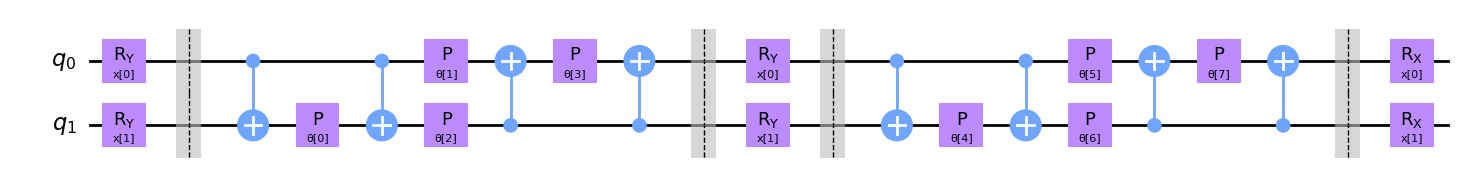

In [43]:
M = 2
layer_par_n = 4
layers_n = 2

theta_list = ParameterVector('θ', length = layer_par_n*layers_n)
data_list  = ParameterVector('x', length = M)


def make_circuit(layers_n):
    
    M = 2
    layer_par_n = 4
    circuit = QuantumCircuit(M)

    for layer in range(layers_n):
        
        for k in range(M):
            circuit.ry(data_list[k],k) 
        circuit.barrier()

        circuit.cx(0,1) 
        circuit.p(theta_list[layer*layer_par_n],1) 
        circuit.cx(0,1)  

        circuit.p(theta_list[layer*layer_par_n + 1],0) 
        circuit.p(theta_list[layer*layer_par_n + 2],1)

        circuit.cx(1,0) 
        circuit.p(theta_list[layer*layer_par_n + 3],0) 
        circuit.cx(1,0) 
        circuit.barrier()
        
    for k in range(M):
        circuit.rx(data_list[k],k)

    return  circuit

my_circ = make_circuit(layers_n)
my_circ.draw("mpl")

In [44]:
from scipy.optimize import minimize
from sklearn.svm import SVC  

progress = []
test_results = []
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)

class QTK:

    def __init__(self, data, circuit, train_size):
        self.data = data_prep(data, train_size)
        self.train_size = train_size
        self.circuit = circuit
    
    def plot_data(self):
        X_train, X_test, y_train, y_test = data_prep((self.data), self.train_size)
        _, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
        train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='copper')
        train_ax.set_ylabel("Feature #1")
        train_ax.set_xlabel("Feature #0")
        train_ax.set_title("Training data")
        test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='copper')
        test_ax.set_xlabel("Feature #0")
        _ = test_ax.set_title("Testing data")


    def cost(self, params):
        circ = self.circuit.assign_parameters({theta_list: params})
        kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=circ)
        X_train = self.data[0]
        X_train_1 = self.data[0][:self.train_size]
        X_train_2 = self.data[0][self.train_size:]
        kernel_matrix = kernel.evaluate(x_vec=X_train) / len(X_train)
        rho = kernel.evaluate(x_vec=X_train_1) / (2*len(X_train_1))
        sigma = kernel.evaluate(x_vec=X_train_2) / (2*len(X_train_2))
        separated_matrix = np.kron(np.array([[1,0],[0,0]]), rho) + np.kron(np.array([[0,0],[0,1]]), sigma) 
        hs = hs_dist(separated_matrix, kernel_matrix)
        # c1 = 0.5*(1 - 0.5*(np.trace(np.matmul(rho,rho)) + np.trace(np.matmul(sigma,sigma)) - hs)) 
        outcome = hs

        return np.round(outcome,4)
    
    def get_svc(self, params): 
        X_train = self.data[0]
        y_train = self.data[2]

        kernel = self.circuit.assign_parameters({theta_list: params})
        kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=kernel)
        func = lambda a,b : kernel.evaluate(a,b)
        model_svc = SVC(kernel= func)
        model_svc.fit(X_train, y_train)
        return model_svc
    
    def test_performance(self, params):
        model_svc = self.get_svc(params)
        return model_svc.score(X_test, y_test)
    

    def plot_boundaries(self, coef_t, coef_nt): 

        X_train = self.data[0]
        X_train_1 = self.data[0][:self.train_size]
        X_train_2 = self.data[0][self.train_size:]

        model_svc_no_training = self.get_svc(coef_nt)
        model_svc = self.get_svc(coef_t)

        _, axs = plt.subplots(1, 2, figsize=(12, 5))
        h = (x_max - x_min)/20
        xx, yy = np.meshgrid(np.arange(x_min, x_max+h, h), np.arange(y_min, y_max+h, h))

        # just plot the dataset first
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(["#FF0000", "#0000FF"])
        axs[0].scatter(
            X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
        )
        axs[0].set_xlim(x_min, x_max)
        axs[0].set_ylim(y_min, y_max)
        axs[0].set_xticks(())
        axs[0].set_yticks(())
        Z = model_svc_no_training.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        axs[0].contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4)
        axs[0].set_title("Decision boundaries without encoding optimization")

        axs[1].scatter(
            X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
        )
        axs[1].set_xlim(x_min, x_max)
        axs[1].set_ylim(y_min, y_max)
        axs[1].set_xticks(())
        axs[1].set_yticks(())
        Z = model_svc.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        axs[1].contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4)
        axs[1].set_title("Decision boundaries with encoding optimization")

        plt.show()

    def callback(self, xk):  
        res = self.cost(xk)
        progress.append(res)
        test = self.test_performance(xk)
        test_results.append(test)
        print("Iteration ", len(progress),": C =  ", res, "Test results ", test, "Parameters are", xk)
        # print("Iteration ", len(progress),": C =  ", res)

    def train(self, coef):
        out = minimize(self.cost, 
                    x0=coef, 
                    method="COBYLA",
                    callback=self.callback, 
                    options={'maxiter':100})
        return out
    
    def get_results(self, coef_t, coef_nt):
        X_test = self.data[1]
        y_test = self.data[3]

        model_svc = self.get_svc(coef_t)
        model_score_callable_function = model_svc.score(X_test, y_test)

        model_svc_no_training = self.get_svc(coef_nt)
        model_score_callable_function_no_training = model_svc_no_training.score(X_test, y_test)

        # print(f"Callable kernel classification test score: {model_score_callable_function}")
        print(f"Classification Model                        | Accuracy Score")
        print(f"---------------------------------------------------------")
        print(f"Precomputed kernel matrix with training     | {model_score_callable_function:10.2f}")
        print(f"Precomputed kernel matrix without training  | {model_score_callable_function_no_training :10.2f}")
    
    def plot_kernels(self, coef_t, coef_nt):

        kernel_final = self.circuit.assign_parameters({theta_list: coef_t})
        kernel_final = FidelityQuantumKernel(fidelity=fidelity, feature_map=kernel_final)
        kernel_matrix_final = kernel_final.evaluate(x_vec=X_train) / len(X_train)

        kernel_circuit = self.circuit.assign_parameters({theta_list: coef_nt})
        kernel_no_training = FidelityQuantumKernel(fidelity=fidelity, feature_map=kernel_circuit)
        kernel_matrix_no_training = kernel_no_training.evaluate(x_vec=X_train) / len(X_train)

        _, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[1].imshow(
            np.asmatrix(kernel_matrix_final), interpolation="nearest", origin="upper", cmap="Greens"
        )
        axs[1].set_title("Kernel matrix after encoding optimization")

        axs[0].imshow(np.asmatrix(kernel_matrix_no_training), interpolation="nearest", origin="upper", cmap="Greens")
        axs[0].set_title("Kernel matrix without encoding otimization")

        plt.show()
    
    def plot_cost(self): 
        pass

In [45]:
my_circ = make_circuit(layers_n)
qtk_model = QTK(data, my_circ, 15)
coef = [1,0,8,0]*layers_n
# coef = [1,1,1,1]*layers_n
# out = qtk_model.train(coef)

def read_data(file_path, pos):
    names = ['moons', 'circles', 'linear'] 
    if pos not in names:
        raise ValueError("wrong name of the dataset")
    array_data = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith(pos):                
                array_data_str = line[len(pos):]
                # Convert the space-separated string to a list of integers
                array_data = list(map(float, array_data_str.split()))
    return np.array(array_data, dtype=float)

file_path = 'out.txt'
# out = read_data(file_path, 'circles')
out = read_data(file_path, 'linear')
print(out)
# out = out.x

[ 0.979372  1.517811  7.901865 -0.349168  2.105878  1.040287  8.368818
 -0.341508]


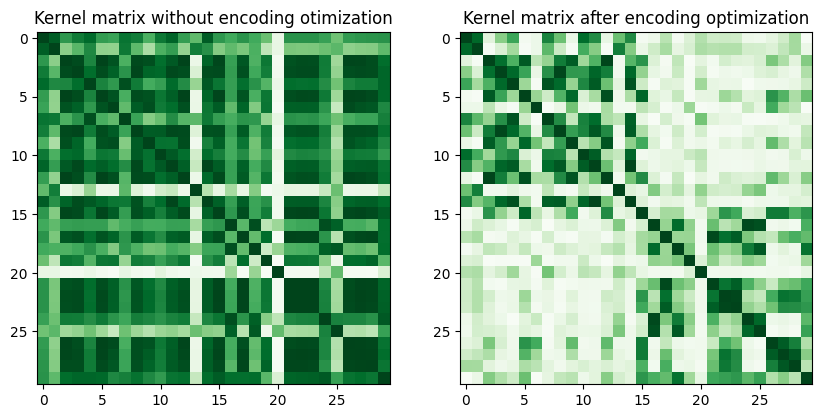

In [46]:
coef = [2, 0, 8, 0, 1, 0, 8, 0]
# res = out.x
res = out
qtk_model.plot_kernels(res,coef)

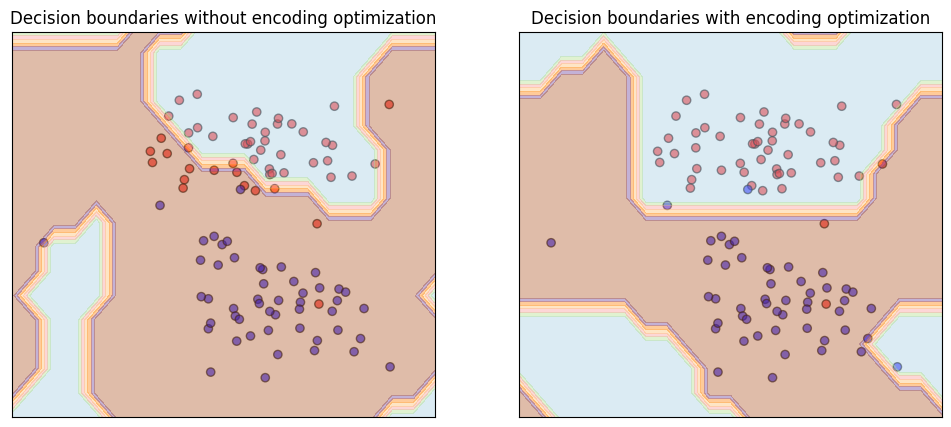

In [47]:
# qtk_model.plot_boundaries(coef, out.x)
qtk_model.plot_boundaries(out, coef)

In [48]:
X_train = qtk_model.data[0]
X_train_1 = qtk_model.data[0][:qtk_model.train_size]
X_train_2 = qtk_model.data[0][qtk_model.train_size:]

coef_nt = [2, 0, 8, 0, 1, 0, 8, 0]
# coef_t = out.x
coef_t = out
model_svc_no_training = qtk_model.get_svc(coef_nt)
model_svc = qtk_model.get_svc(coef_t)

h = (x_max - x_min)/20
xx, yy = np.meshgrid(np.arange(x_min, x_max+h, h), np.arange(y_min, y_max+h, h))

Z_nt = model_svc_no_training.predict(np.c_[xx.ravel(), yy.ravel()])
Z_t = model_svc.predict(np.c_[xx.ravel(), yy.ravel()])

In [49]:
Z_t.shape, xx.shape[0] * xx.shape[1]

((357,), 357)

In [50]:
def clean_file(file_path):
    with open(file_path, 'w') as file:
        file.write("")

    print("File content cleaned.")
    

# Function to remove lines containing a specific keyword from the file
def remove_lines(file_path, keyword):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Filter out lines containing the specified keyword
    filtered_lines = [line for line in lines if keyword not in line]

    with open(file_path, 'w') as file:
        file.writelines(filtered_lines)

def add_line(file_path, data, pos):
    c = 0
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith(pos):
                print(line.startswith(pos))
                print("Can not add: the position is not empty!")
                return 
    
    with open(file_path, 'a') as file:
        file.write(pos)
        np.savetxt(file, data, newline=' ', fmt='%f')  # Save the array
        file.write("\n")
    print("Successfully added")

In [51]:
name = 'linear'
file_path = 'results.txt'
# # clean_file(file_path)

name_nt = name + '_nt'
remove_lines(file_path, keyword = name_nt)
add_line(file_path, Z_nt, name_nt)

name_t = name + '_t'
remove_lines(file_path, keyword = name_t)
add_line(file_path, Z_t, name_t)

# # clean_file('out.txt')
# remove_lines('out.txt', keyword = name)
# add_line('out.txt', out, name)

Successfully added
Successfully added


In [52]:
def moving_avg(A):
    m = A[0]
    B = []
    B.append(m)
    for i in range(1,len(A)):
        m = (m * i + A[i])/(i+1)
        B.append(m)
    return B

steps = 82
xpoints = np.arange(steps)
ypoints = np.array(progress)

y_av = moving_avg(ypoints)
zpoints = 1 - np.array(test_results)
z_av = moving_avg(zpoints)

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(xpoints, ypoints, color = 'b') 
axs[0].plot(xpoints, zpoints, color = 'r')

axs[1].plot(xpoints, y_av, color = 'b')
axs[1].plot(xpoints, z_av, color = 'r')

plt.suptitle('Cost Function Optimisation')
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# clean_file('progress.txt')
# remove_lines('progress.txt', keyword = name +'_cost_nb')
# add_line('progress.txt', ypoints, name + '_cost_nb')

# remove_lines('progress.txt', keyword = name + '_accuracy_nb')
# add_line('progress.txt', zpoints, name + '_accuracy_nb')

name = 'circles'
# remove_lines('progress.txt', keyword = name + '_cost_ema_nb')
# add_line('progress.txt', y_av, name + '_cost_ema_nb')

# remove_lines('progress.txt', keyword = name + '_accuracy_ema_nb')
# add_line('progress.txt', z_av, name + '_accuracy_ema_nb')

NameError: name 'remove_lines' is not defined

In [ ]:
import numpy as np

n = 5  # Size of the square matrix
matrix = np.random.rand(n, n)

def low_rank_approximation(matrix, rank):
    U, S, V = np.linalg.svd(matrix)
    approx_matrix = np.dot(U[:, :rank] * S[:rank], V[:rank, :])
    print(S[:rank])
    return approx_matrix

# Example usage
# Assuming you have a matrix represented as a numpy array called 'matrix'
n = matrix.shape[0]  # Assuming the matrix is square
rank = 4  # Desired rank for the low-rank approximation

approx_matrix = low_rank_approximation(matrix, rank)
frobenius_norm = np.linalg.norm(approx_matrix - matrix, ord='fro')
print("Frob. norm:", frobenius_norm)

[2.7446666  0.9257778  0.55021292 0.40200634]
Frob. norm: 0.11224428491089473


In [ ]:
kernel_final = qtk_model.circuit.assign_parameters({theta_list: res})
kernel_final = FidelityQuantumKernel(fidelity=fidelity, feature_map=kernel_final)
kernel_matrix_final = kernel_final.evaluate(x_vec=X_train) / len(X_train)

approx_2 = low_rank_approximation(kernel_matrix_final, 2)
approx_1 = low_rank_approximation(kernel_matrix_final, 1)
frobenius_norm = np.linalg.norm(approx_2 - kernel_matrix_final, ord='fro')
frobenius_norm_approx = np.linalg.norm(approx_1 - approx_2, ord='fro')
print("Frob. norm of the difference:", frobenius_norm)
print("Rank 1 approx - Rank 2 approx difference:", frobenius_norm_approx)

[0.36477614 0.21717793]
[0.36477614]
Frob. norm of the difference: 0.2033339883134687
Rank 1 approx - Rank 2 approx difference: 0.217177933146639


In [ ]:
kernel_circuit = qtk_model.circuit.assign_parameters({theta_list: coef})
kernel_no_training = FidelityQuantumKernel(fidelity=fidelity, feature_map=kernel_circuit)
kernel_matrix_no_training = kernel_no_training.evaluate(x_vec=X_train) / len(X_train)

approx_2 = low_rank_approximation(kernel_matrix_no_training, 2)
approx_1 = low_rank_approximation(kernel_matrix_no_training, 1)
frobenius_norm = np.linalg.norm(approx_2 - kernel_matrix_no_training, ord='fro')
frobenius_norm_approx = np.linalg.norm(approx_1 - approx_2, ord='fro')
print("Frob. norm of the difference:", frobenius_norm)
print("Rank 1 approx - Rank 2 approx difference:", frobenius_norm_approx)

[0.75227242 0.11485037]
[0.75227242]
Frob. norm of the difference: 0.06960564719111836
Rank 1 approx - Rank 2 approx difference: 0.11485036880813876
